Import Libraries

In [1]:
#import necessary libraries
#nltk.download()
!pip install nltk
!pip install -U scikit-learn

import nltk
import random
import re
import pandas as pd
import numpy as np
import os
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import gensim
from wordcloud import WordCloud


warnings.filterwarnings("ignore")

from nltk.corpus import gutenberg
from nltk.tokenize import regexp_tokenize,word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import ngrams

from gensim.models import Word2Vec , LdaModel
from collections import Counter
from sklearn.manifold import TSNE

from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,silhouette_score, cohen_kappa_score
from sklearn.model_selection import train_test_split,cross_val_score ,cross_validate,cross_val_predict
from sklearn import preprocessing
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler ,LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA

nltk.download('stopwords')
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
genre_books={}
listBooks = gutenberg.fileids()
# Get the author names and book titles for each drama book
for book in listBooks:
    # Extract the author name from the felid
    author_line = gutenberg.raw(book).split('\n')[0]
    author_name = author_line.split("by", 1)[-1].strip().replace("]", "").replace("by","")
    # Remove the year from the author name using regular expressions
    author_name = re.sub(r'\b\d{4}\b', '', author_name).strip()

    # Extract the book title from the felid
    title =book.split('/')[-1]

    # Check if the book is related to drama
    if 'history'or'romance'or'adventure'or'mystery'or'horror'or'drama' in nltk.corpus.gutenberg.raw(book).lower():
      genre_books[title]=author_name

genre_books


{'austen-emma.txt': 'Jane Austen',
 'austen-persuasion.txt': 'Jane Austen',
 'austen-sense.txt': 'Jane Austen',
 'bible-kjv.txt': '[The King James Bible',
 'blake-poems.txt': 'William Blake',
 'bryant-stories.txt': 'Sara Cone Bryant',
 'burgess-busterbrown.txt': 'Thornton W. Burgess',
 'carroll-alice.txt': 'Lewis Carroll',
 'chesterton-ball.txt': 'G.K. Chesterton',
 'chesterton-brown.txt': 'G. K. Chesterton',
 'chesterton-thursday.txt': 'G. K. Chesterton',
 'edgeworth-parents.txt': 'Maria Edgeworth',
 'melville-moby_dick.txt': 'Dick  Herman Melville',
 'milton-paradise.txt': 'John Milton',
 'shakespeare-caesar.txt': 'William Shakespeare',
 'shakespeare-hamlet.txt': 'William Shakespeare',
 'shakespeare-macbeth.txt': 'William Shakespeare',
 'whitman-leaves.txt': 'Walt Whitman'}

In [3]:
#chosee 5 diff books for 5 diff author and genre
selected_books=['austen-emma.txt','whitman-leaves.txt','milton-paradise.txt', 'melville-moby_dick.txt','chesterton-thursday.txt']
selected_books

['austen-emma.txt',
 'whitman-leaves.txt',
 'milton-paradise.txt',
 'melville-moby_dick.txt',
 'chesterton-thursday.txt']

Preprocessing

In [4]:
def clean_text(text):

    #remove punctuation and strange characters
    lemmatizer = WordNetLemmatizer()
    sub_pattern = r'[^A-Za-z]'
    split_pattern = r"\s+"

    #remove stop words
    stop_words = stopwords.words('english') + ['never','ever','couldnot','wouldnot','could','would','us',"i'm","you'd"]

    # Converting all words into lower case.
    lower_book = text.lower()

    # Replacing all characters except those in the pattern into spaces.
    filtered_book = re.sub(sub_pattern,' ',lower_book).lstrip().rstrip()

     # tokenizethe whole book into words in a list.
    filtered_book = word_tokenize(filtered_book)
    filtered_book = [lemmatizer.lemmatize(word) for word in filtered_book if word not in stop_words]

    return filtered_book

In [5]:
#label books Names with a unique label (even if there are more than 26 book)(book 27->aa)(book 28 -->ab)
book_map = {}
for i, book_name in enumerate(selected_books):
    label = chr(ord('a') + i)
    book_map[book_name] = label

In [6]:
def prepareBook( Partitons_num,num_of_words):

    df = pd.DataFrame(columns=["Partitions","Book Name","Book Label","Book Author"])

    for id,book in enumerate(selected_books):

        # import data from Gutenberg by using .raw() function
        raw_text = gutenberg.raw(book)

        #print(len(raw_text))

        #clean book Text
        cleaned_book= clean_text(raw_text)

        #print(len(cleaned_book))

        # tokenization of words (more then 3 chars ) by using word_tokenize() function.
        tokens = nltk.regexp_tokenize(str(cleaned_book), r'\w{3,}')
        data_Partition=[]
        seed=42
        # create (Partitons_num) random sample of number of words for each book.
        # use for loop
        for i in range(Partitons_num):

            # Use random.randint() function to randomly pick a start position for selecting the 150 words
            # Select num_of_word words from the start position
            start_pos = random.randint(0, len(tokens) - num_of_words)

            # divide the tokenized words into partitions and label the partitions
            partitions_tokens = tokens[start_pos:start_pos + num_of_words]

            #join all tokens in one sentence
            partitions = ' '.join(partitions_tokens)

            #data frame prepartion

            bookName = book.split('-')[1].capitalize()
            bookLabel=book_map[book]
            bookAuthor= genre_books[book]


            # use append function to label each Partion to the corresponding label (e.g., author name)
            df.loc[len(df)] = [partitions,bookName, bookLabel, bookAuthor]
    return df

In [7]:
df=prepareBook(200,150)
df

,Partitions,Book Name,Book Label,Book Author
0,writes one best gentleman hand saw admire said...,Emma.txt,a,Jane Austen
1,emma saved rapture fondness moment dreadful pe...,Emma.txt,a,Jane Austen
2,nothing want change serious miss woodhouse wha...,Emma.txt,a,Jane Austen
3,shew delightful well judging truly amiable wom...,Emma.txt,a,Jane Austen
4,william larkins old acquaintance always glad s...,Emma.txt,a,Jane Austen
...,...,...,...,...
995,help liking old sunday admiration force silly ...,Thursday.txt,e,G. K. Chesterton
996,bull boiling good sense optimism broke suddenl...,Thursday.txt,e,G. K. Chesterton
997,spoke old innkeeper blue eye white hair came a...,Thursday.txt,e,G. K. Chesterton
998,back spike yellow beard almost pointed ceiling...,Thursday.txt,e,G. K. Chesterton


Book Distribution

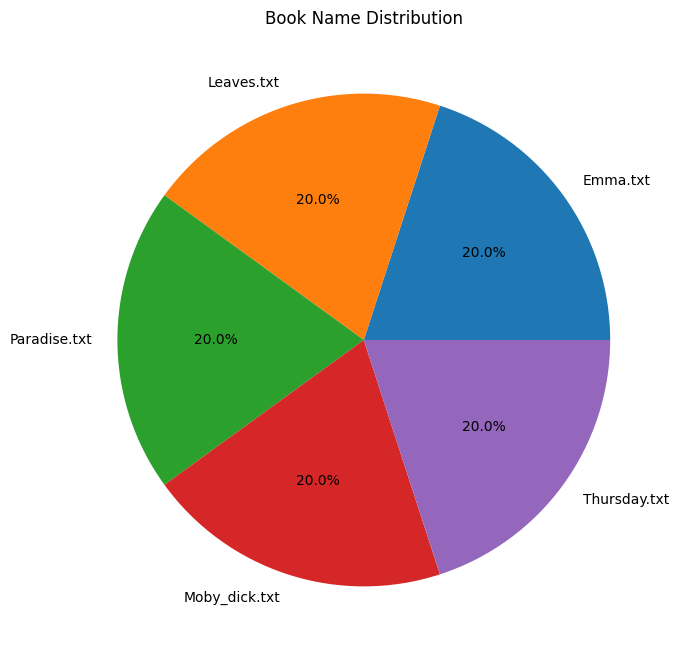

In [8]:
plt.figure(figsize=(10, 8))
book_counts = df['Book Name'].value_counts()
labels = book_counts.index
plt.pie(book_counts, labels=labels, autopct='%1.1f%%')
plt.title('Book Name Distribution')
plt.show()

Word Cloud of each Document

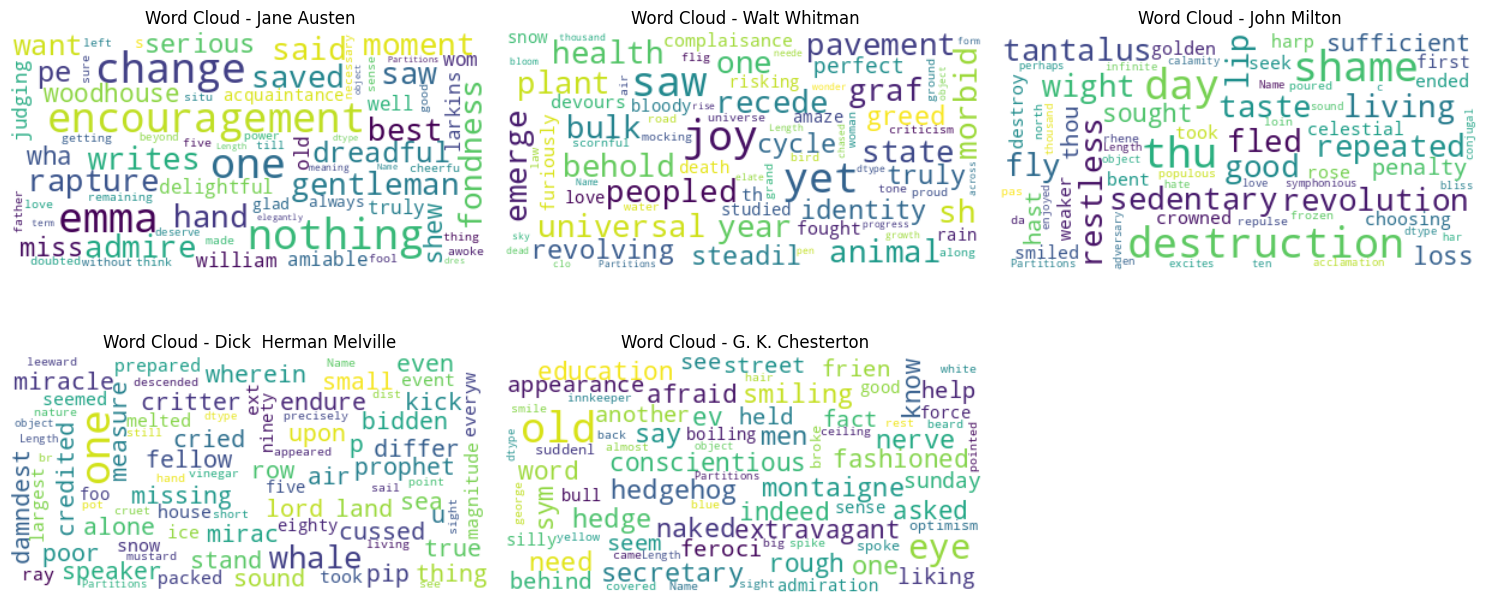

In [9]:
# Define the grid layout
num_rows = 2
num_cols = 3

# Calculate the total number of subplots
num_subplots = num_rows * num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 7))

# Plot word cloud for each book
for i, label in enumerate(df['Book Author'].unique()):
    if i < num_subplots:
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]

        books = df[df["Book Author"] == label]["Partitions"]

        # Wordcloud
        ax.set_title(f"Word Cloud - {label}")
        wc = WordCloud(background_color='white', max_words=100, max_font_size=35)
        wc = wc.generate(str(books))
        ax.imshow(wc, interpolation='bilinear')
        ax.axis('off')
    else:
        break

# Remove empty subplots
if i+1 < num_subplots:
    for j in range(i+1, num_subplots):
        row = j // num_cols
        col = j % num_cols
        fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()


### **Text Transformation**

In [10]:
def Words_Relations (T_df, T_Name):
    from yellowbrick.text import TSNEVisualizer
    tsne = TSNEVisualizer(title=" Words Relations in"+ T_Name+" transformatiom")
    tsne.fit(T_df,df["Book Author"])
    tsne.show()

## **(1) Bag of Words**

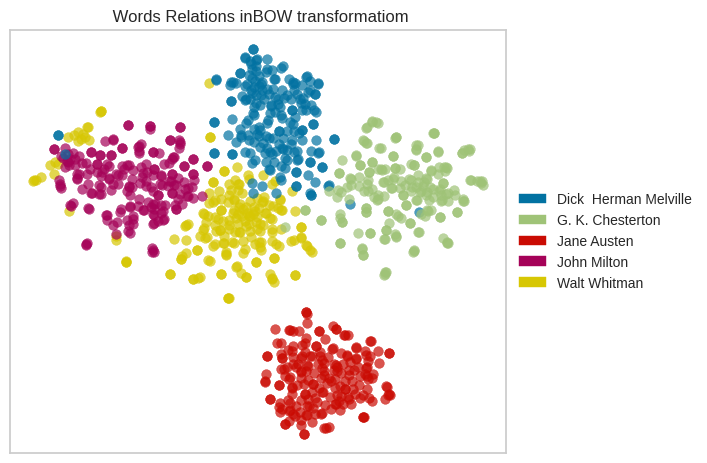

In [11]:
##BOW
count_vectorizer = CountVectorizer()
BOW_vectors = count_vectorizer.fit_transform(df["Partitions"])
feature_names = count_vectorizer.get_feature_names_out()

# Convert the BOW vectors to a dataframe
X_BOW = pd.DataFrame(BOW_vectors.toarray(), columns=feature_names)
#Draw Chart showing word Relations
#print(X_BOW)
Words_Relations (X_BOW ,"BOW")

# **(2) TF-IDF**


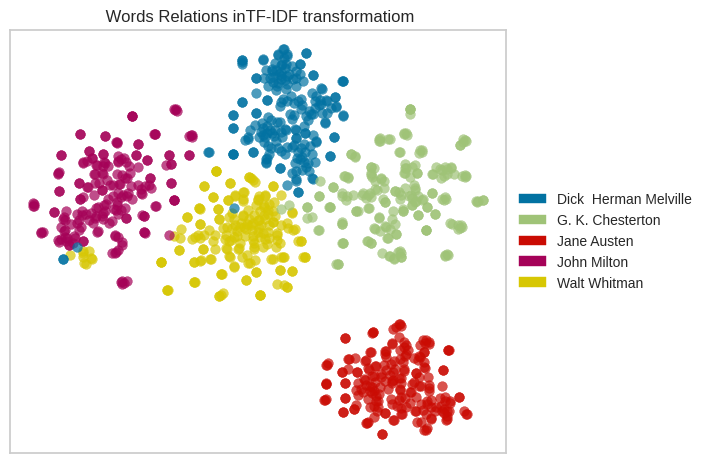

In [12]:
#TF
# Create the TF-IDF vectors
TFidf_vect = TfidfVectorizer()
TFidf_vectors = TFidf_vect.fit_transform(df["Partitions"])

 # Convert the TF-IDF vectors to a dataframe#
 # Split the TF dataset into input features X and output labels y
X_TF = pd.DataFrame(TFidf_vectors.toarray(), columns=TFidf_vect.get_feature_names_out())

#Draw Chart showing word Relations
#print(X_TF)
Words_Relations (X_TF ,"TF-IDF")

## **(3)LDA**

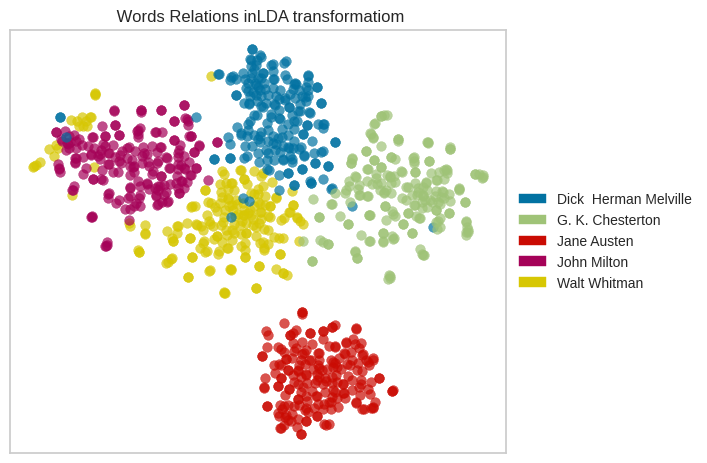

In [13]:
##LDA

# Initialize the CountVectorizer
count_vectorizer = CountVectorizer()

# Fit and transform the text data
LDA_vectors = count_vectorizer.fit_transform(df["Partitions"])

# Get the feature names
feature_names = count_vectorizer.get_feature_names_out()


# Initialize the LDA model
lda_model = LatentDirichletAllocation(n_components=10)  # Specify the number of topics

# Fit the LDA model to the data
lda_model.fit(LDA_vectors)

# Convert the BOW vectors to a dataframe
X_LDA = pd.DataFrame(LDA_vectors.toarray(), columns=feature_names)

# Draw chart showing word relations
"""
def words_relations(lda_model, feature_names):
    for idx, topic in enumerate(lda_model.components_):
        print(f"Topic #{idx}")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))
        print()

words_relations(lda_model, feature_names)
"""
#print(X_LDA)
Words_Relations (X_LDA ,"LDA")

## **(4) Word Embedding**

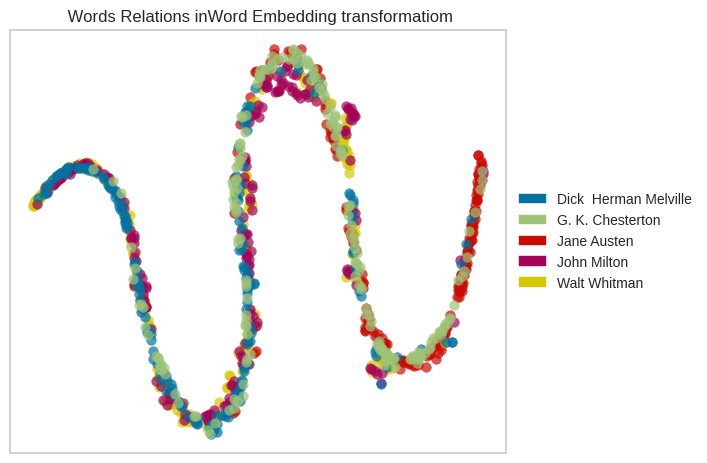

In [14]:
#  Word2Vec
sentences = [doc.split() for doc in df["Partitions"]]
embedding_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Get word embeddings for BOW vectors
word_embeddings = []
for doc in df["Partitions"]:
    doc_embedding = np.zeros(100)  # Assuming embedding size is 100
    word_count = 0
    for word in doc.split():
        if word in embedding_model.wv:
            doc_embedding += embedding_model.wv[word]
            word_count += 1
    if word_count > 0:
        doc_embedding /= word_count
    word_embeddings.append(doc_embedding)

# Convert word embeddings to a dataframe
X_Word_Embedding = pd.DataFrame(word_embeddings)

#Draw Chart showing word Relations
#print(X_Word_Embedding )
Words_Relations (X_Word_Embedding ,"Word Embedding")

## **Models and Evaluation**

In [15]:
#Encoding
label_encoder = LabelEncoder()
actual_Label=label_encoder.fit_transform(df['Book Label'])

# (1) K-Means

In [16]:
def assign_clusters(model_labels, actual_Label,num_class=5):

    map_Books = {}
    for i in range(num_class):
        start_index = i * 200
        end_index = (i + 1) * 200
        map_Books[i] = dict(Counter(model_labels[start_index:end_index]))

    #print(map_Books)

    # Function to find occurrences of a given cluster in each book
    def find_cluster_occurrences(cluster):
        cluster_occurrences = {}
        for book, labels in map_Books.items():
            if cluster in labels:
                cluster_occurrences[book] = labels[cluster]
        return cluster_occurrences

    # Function to find the number of books in which a given cluster occurs
    def find_num_books(cluster):
        count = 0
        for labels in map_Books.values():
            if cluster in labels:
                count += 1
        return count

    visited_books = set()  # Set to track visited books
    book_clusters = {}  # Dictionary to store the assigned cluster for each book

    # Sort the clusters based on the number of books in which they occur
    sorted_clusters = sorted(range(5), key=find_num_books)

    # Iterate over sorted clusters
    for cluster in sorted_clusters:
        cluster_occurrences = find_cluster_occurrences(cluster)
        sorted_occurrences = sorted(cluster_occurrences.items(), key=lambda x: x[1], reverse=True)

        done = False
        for book, count in sorted_occurrences:
            if book not in visited_books and not done:
                book_clusters[book] = cluster
                visited_books.add(book)
                done = True

    #map Books with its new cluster
    book_clusters = dict(sorted(book_clusters.items()))
    #print (book_clusters)

    for indx, (book, cluster) in enumerate(book_clusters.items()):
         actual_Label[indx*200:200*indx+200]=int (cluster)
         #print(cluster)
    return actual_Label

In [17]:
Silhouette = {'K-Means': set(), 'EM': set(), 'Hierarchical': set()}
Kappa = {'K-Means': set(), 'EM': set(), 'Hierarchical': set()}

In [18]:
#Dim reduction and Kmean Model
def C_ML_Models(T_df,n):

  X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=40).fit_transform(T_df)

  algorithm = KMeans(n_clusters=n, random_state=42)

  algorithm.fit_predict(X_embedded)
  model_labels = algorithm.predict(X_embedded)
  sil_avg = silhouette_score(X_embedded, model_labels)

  # Applay Mapping
  n_labels=assign_clusters(model_labels,actual_Label,num_class=5)
  #print(n_labels)

  # Calculate Kappa
  kapb=cohen_kappa_score( model_labels,n_labels)


  print(f"\nSilhouette Score (K-Means): {sil_avg}\n")
  print(f"Kappa Score (K-Means): {kapb }\n")

  return sil_avg,kapb

KMean With BOW

In [19]:
KMeans_Silhouette_BOW,KMeans_Kappa_BOW= C_ML_Models(X_BOW,5)

Silhouette['K-Means'].add(('BOW', KMeans_Silhouette_BOW))
Kappa['K-Means'].add(('BOW',KMeans_Kappa_BOW))


Silhouette Score (K-Means): 0.45304977893829346

Kappa Score (K-Means): 0.78375



KMean With LDA

In [20]:
KMeans_Silhouette_LDA,KMeans_Kappa_LDA =C_ML_Models(X_LDA,5 )

Silhouette['K-Means'].add(('LDA', KMeans_Silhouette_LDA))
Kappa['K-Means'].add(('LDA',KMeans_Kappa_LDA))


Silhouette Score (K-Means): 0.4632692337036133

Kappa Score (K-Means): 0.825



KMean With TF

In [21]:
KMeans_Silhouette_TF,KMeans_Kappa_TF=C_ML_Models(X_TF,5)

Silhouette['K-Means'].add(('TF', KMeans_Silhouette_TF))
Kappa['K-Means'].add(('TF',KMeans_Kappa_TF))


Silhouette Score (K-Means): 0.5178417563438416

Kappa Score (K-Means): 0.95625



KMean With Word Embedding

In [22]:
KMeans_Silhouette_WE,KMeans_Kappa_WE=C_ML_Models(X_Word_Embedding,5)

Silhouette['K-Means'].add(('Word Embedding', KMeans_Silhouette_WE))
Kappa['K-Means'].add(('Word Embedding',KMeans_Kappa_WE))


Silhouette Score (K-Means): 0.544873058795929

Kappa Score (K-Means): 0.04500000000000004



## **(2) Expectation Maximization (EM)**

In [23]:
def EM_ML_Models(T2_df,n):


    emX_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=40).fit_transform(T2_df)

    algorithm = GaussianMixture(n_components=n, random_state=42)


    algorithm.fit_predict(emX_embedded)
    em_model_labels = algorithm.predict(emX_embedded)
    sil_em_avg = silhouette_score(emX_embedded, em_model_labels)

    # Applay Mapping
    gn_labels=assign_clusters(em_model_labels,actual_Label,num_class=5)
    #print(n_labels)
    # Calculate Kappa
    gkapp=cohen_kappa_score(em_model_labels,gn_labels)

    print(f"\nSilhouette Score (Expectation Maximization): {sil_em_avg}\n")

    print(f"Kappa Score (Expectation Maximization): {gkapp }\n")

    return sil_em_avg ,gkapp


EM With BOW

In [24]:
EM_Silhouette_BOW,EM_Kappa_BOW=EM_ML_Models(X_BOW,5)

Silhouette['EM'].add(('BOW', EM_Silhouette_BOW))
Kappa['EM'].add(('BOW',EM_Kappa_BOW))


Silhouette Score (Expectation Maximization): 0.4630243182182312

Kappa Score (Expectation Maximization): 0.80625



EM With LDA

In [25]:
EM_Silhouette_LDA,EM_Kappa_LDA=EM_ML_Models(X_LDA,5)

Silhouette['EM'].add(('LDA', EM_Silhouette_LDA))
Kappa['EM'].add(('LDA',EM_Kappa_LDA))


Silhouette Score (Expectation Maximization): 0.4578031301498413

Kappa Score (Expectation Maximization): 0.79875



EM With TF

In [26]:
EM_Silhouette_TF,EM_Kappa_TF=EM_ML_Models(X_TF,5)

Silhouette['EM'].add(('TF', EM_Silhouette_TF))
Kappa['EM'].add(('TF',EM_Kappa_TF))


Silhouette Score (Expectation Maximization): 0.5111621618270874

Kappa Score (Expectation Maximization): 0.94625



EM With Word Embedding

In [27]:
EM_Silhouette_WE,EM_Kappa_WE=EM_ML_Models(X_Word_Embedding,5)

Silhouette['EM'].add(('Word Embedding', EM_Silhouette_WE))
Kappa['EM'].add(('Word Embedding',EM_Kappa_WE))



Silhouette Score (Expectation Maximization): 0.4860292077064514

Kappa Score (Expectation Maximization): 0.20125000000000004



## **(3) Hierarchical clustering (Agglomerative)**

In [30]:
import scipy.cluster.hierarchy as sch

def perform_hierarchical_clustering(X):

    dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))
    hc = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
    y_hc = hc.fit_predict(X)
    return y_hc

def H_MODEL(x_x,n):
  hX_embedded = TSNE(n_components=2, learning_rate='auto',
                 init='random', perplexity=40).fit_transform(x_x)
  km_cls=AgglomerativeClustering(n_clusters=n, affinity = 'euclidean')

  hi_labels=km_cls.fit_predict(hX_embedded)
  hsil_avg = silhouette_score(hX_embedded, hi_labels)

  #map
  hn_label=assign_clusters(hi_labels ,actual_Label,num_class=5)
  kapp=cohen_kappa_score(hi_labels,hn_label)
  print(f"\nSilhouette Score (Hierarchical) : {hsil_avg }\n")
  print(f"Kappa Score (Hierarchical)  : {kapp }\n")

  return  hsil_avg,kapp


Hierarchical clustering With BOW


Silhouette Score (Hierarchical) : 0.42036041617393494

Kappa Score (Hierarchical)  : 0.7262500000000001



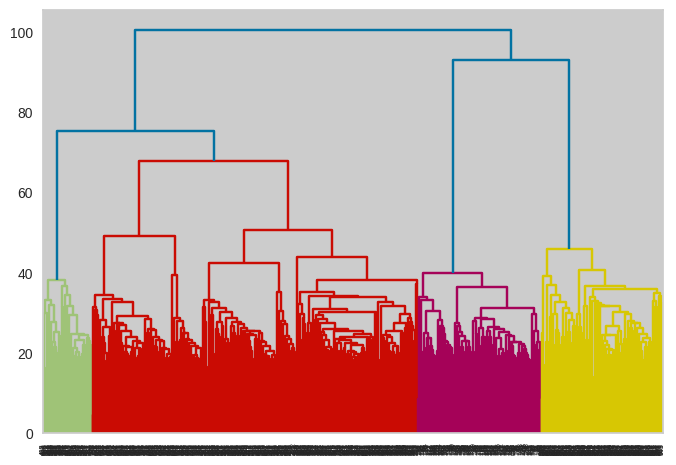

In [31]:
H_Silhouette_BOW,H_Kappa_BOW=H_MODEL(X_BOW,5)
perform_hierarchical_clustering(X_BOW)

Silhouette['Hierarchical'].add(('BOW', H_Silhouette_BOW))
Kappa['Hierarchical'].add(('BOW',H_Kappa_BOW))

Hierarchical clustering With LDA


Silhouette Score (Hierarchical) : 0.41023069620132446

Kappa Score (Hierarchical)  : 0.80875



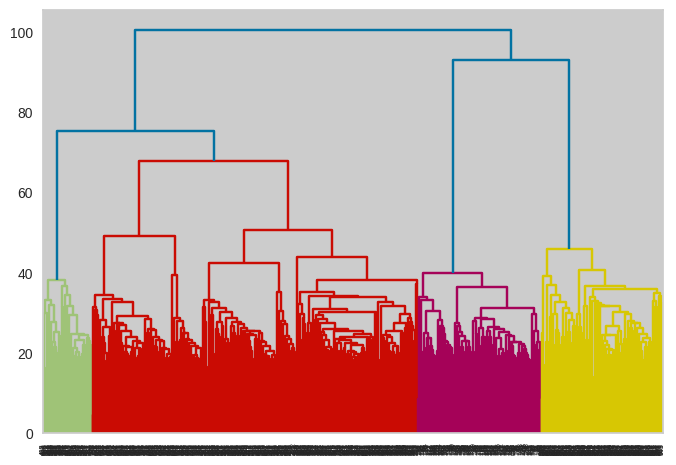

In [32]:
H_Silhouette_LDA,H_Kappa_LDA=H_MODEL(X_LDA,5)
perform_hierarchical_clustering(X_LDA)

Silhouette['Hierarchical'].add(('LDA', H_Silhouette_LDA))
Kappa['Hierarchical'].add(('LDA',H_Kappa_LDA))

Hierarchical clustering With TF


Silhouette Score (Hierarchical) : 0.5191198587417603

Kappa Score (Hierarchical)  : 0.93375



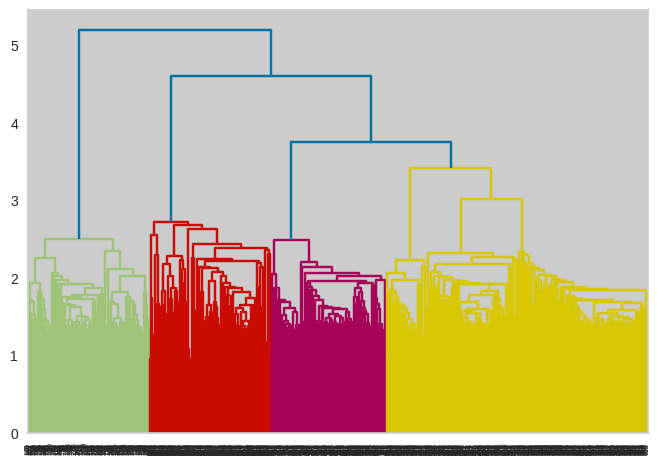

In [33]:
H_Silhouette_TF,H_Kappa_TF=H_MODEL(X_TF,5)
perform_hierarchical_clustering(X_TF)


Silhouette['Hierarchical'].add(('TF', H_Silhouette_TF))
Kappa['Hierarchical'].add(('TF',H_Kappa_TF))

Hierarchical clustering With Word Embedding


Silhouette Score (Hierarchical) : 0.5067201852798462

Kappa Score (Hierarchical)  : 0.1975



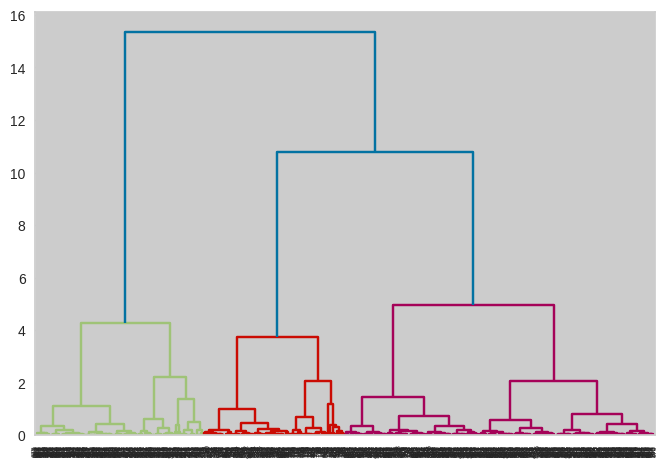

In [34]:
H_Silhouette_WE, H_Kappa_WE=H_MODEL(X_Word_Embedding,5)
perform_hierarchical_clustering(X_Word_Embedding)

Silhouette['Hierarchical'].add(('Word Embedding', H_Silhouette_WE))
Kappa['Hierarchical'].add(('Word Embedding',H_Kappa_WE))

## Champion Transformation/Model

In [35]:
# Initialize empty lists to store the data
silhouette_data = []
kappa_data = []

# Iterate over the Silhouette dictionary and append data to the lists
for model, transformations in Silhouette.items():
    for transformation, score in transformations:
        silhouette_data.append({'Model': model, 'Transformation': transformation, 'Score': score})

# Iterate over the Kappa dictionary and append data to the lists
for model, transformations in Kappa.items():
    for transformation, score in transformations:
        kappa_data.append({'Model': model, 'Transformation': transformation, 'Score': score})


# Create dataframes from the lists
silhouette_df = pd.DataFrame(silhouette_data)
kappa_df = pd.DataFrame(kappa_data)

# Sort dataframes by "Score" column in descending order
silhouette_df = silhouette_df.sort_values(by='Score', ascending=False)
kappa_df = kappa_df.sort_values(by='Score', ascending=False)

In [36]:
# Reset the index of the dataframes
silhouette_df = silhouette_df.reset_index(drop=True)
kappa_df = kappa_df.reset_index(drop=True)

In [37]:
# Print Silhouette dataframe
print("Silhouette DataFrame:")
silhouette_df.style.background_gradient(cmap='Blues')

Silhouette DataFrame:


,Model,Transformation,Score
0,K-Means,Word Embedding,0.544873
1,Hierarchical,TF,0.519120
2,K-Means,TF,0.517842
3,EM,TF,0.511162
4,Hierarchical,Word Embedding,0.506720
5,EM,Word Embedding,0.486029
6,K-Means,LDA,0.463269
7,EM,BOW,0.463024
8,EM,LDA,0.457803
9,K-Means,BOW,0.453050


In [38]:
# Print Kappa dataframe
print("Kappa DataFrame:")
kappa_df.style.background_gradient(cmap='Blues')

Kappa DataFrame:


,Model,Transformation,Score
0,K-Means,TF,0.956250
1,EM,TF,0.946250
2,Hierarchical,TF,0.933750
3,K-Means,LDA,0.825000
4,Hierarchical,LDA,0.808750
5,EM,BOW,0.806250
6,EM,LDA,0.798750
7,K-Means,BOW,0.783750
8,Hierarchical,BOW,0.726250
9,EM,Word Embedding,0.201250


In [39]:
# Display the first element of the champion model dataframe
print("Champion Model Silhouette (First Element):")
champion_df_first = silhouette_df.iloc[0].to_frame()
display(champion_df_first)

Champion Model Silhouette (First Element):


,0
Model,K-Means
Transformation,Word Embedding
Score,0.544873


In [40]:
# Display the first element of the champion model dataframe
print("Champion Model Kappa (First Element):")
champion_df_first =kappa_df.iloc[0].to_frame()
display(champion_df_first)

Champion Model Kappa (First Element):


,0
Model,K-Means
Transformation,TF
Score,0.95625


In [41]:
# Define color palettes for each model
model_colors = {
    'K-Means':['red'],
    'EM': ['green'],
    'Hierarchical':  ['blue']
}

# Function to plot scores for a specific model
def plot_scores(model_name, df,name):
    model_df = df[df['Model'] == model_name]
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Transformation', y='Score', data=model_df, palette=model_colors[model_name])
    plt.xlabel('Transformation')
    plt.ylabel('Score')
    plt.title(f'{model_name} Scores for each Transformation using {name} value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

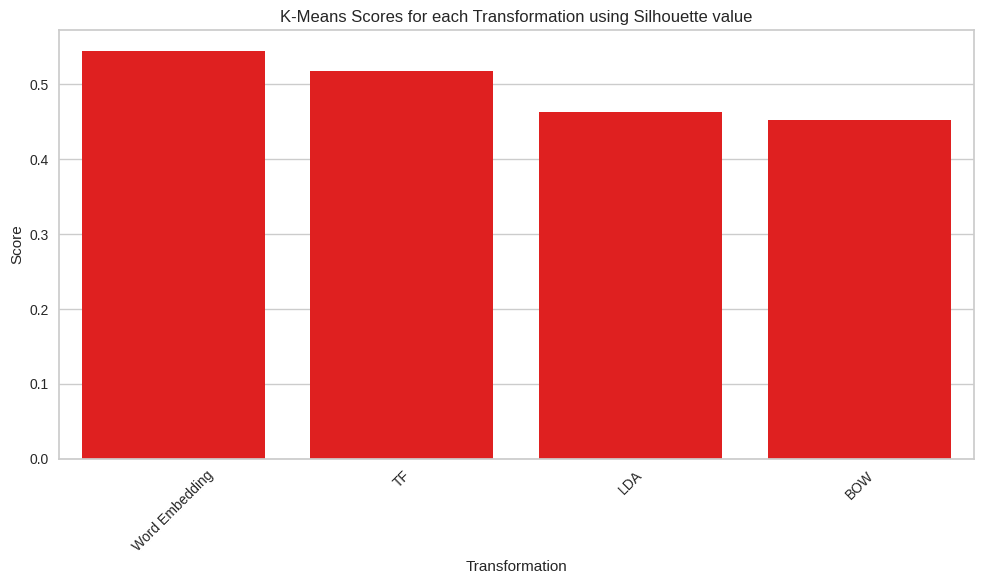

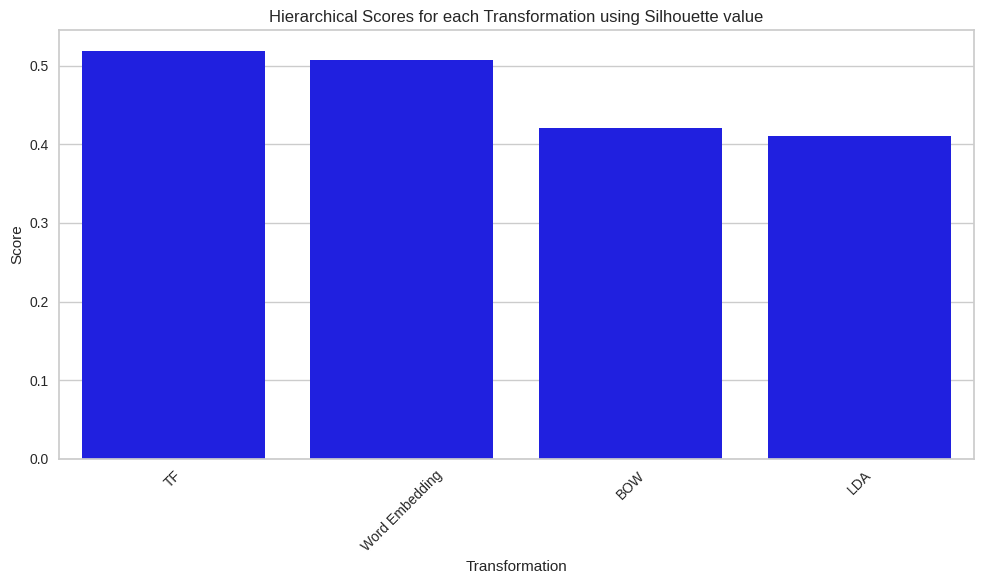

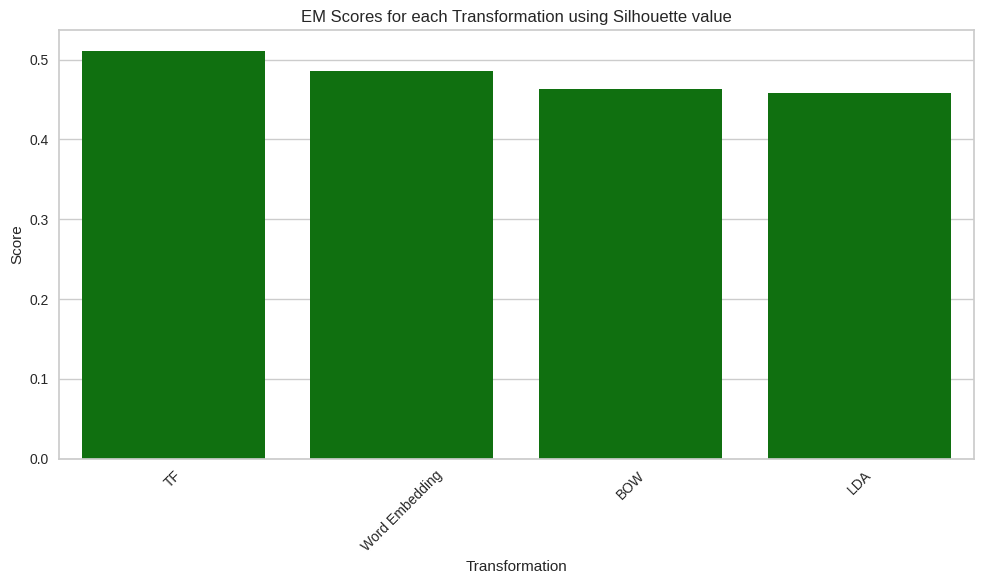

In [42]:
# Plot Silhouette scores for each model
for model in silhouette_df['Model'].unique():
    plot_scores(model, silhouette_df ,'Silhouette')

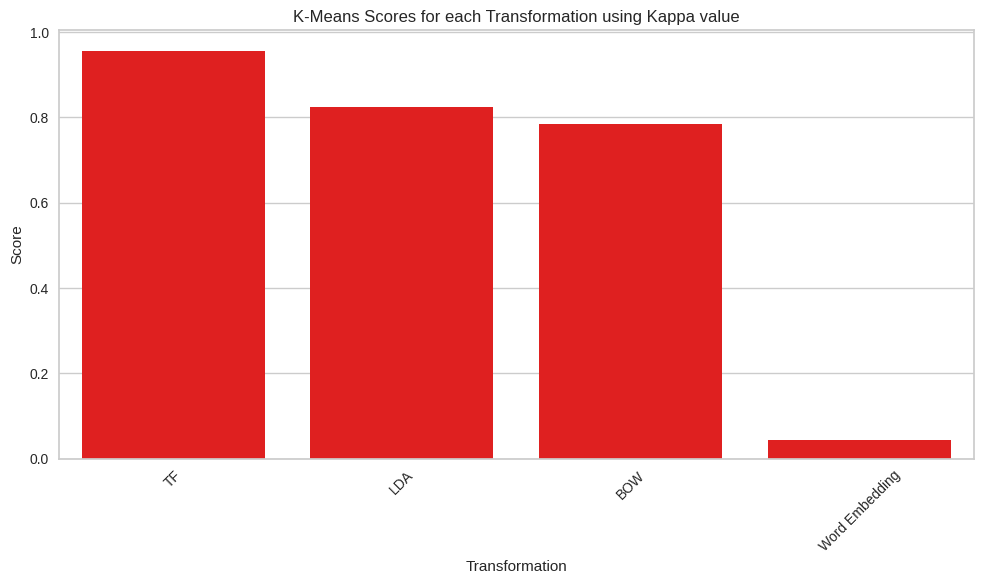

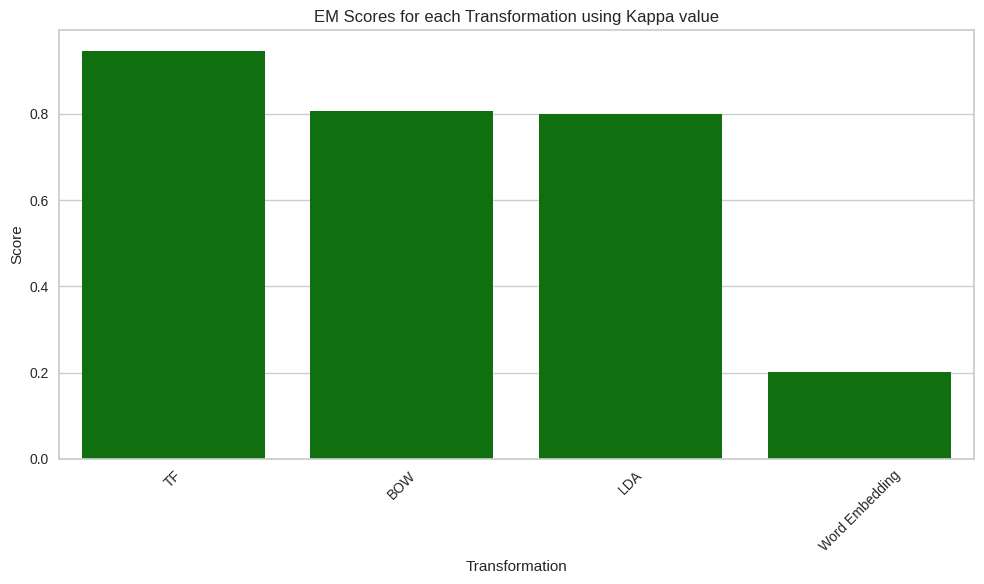

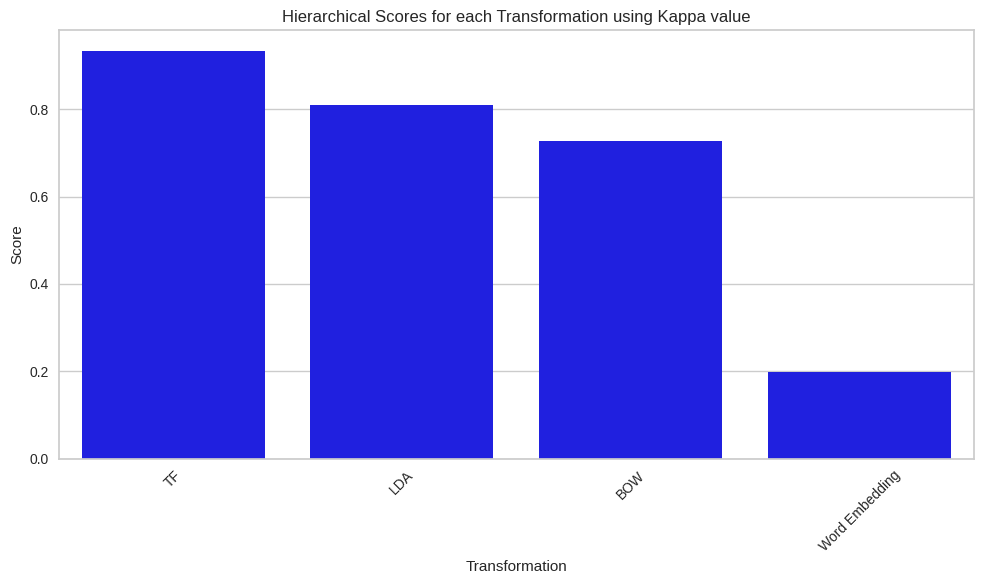

In [43]:
# Plot Kappa scores for each model
for model in kappa_df['Model'].unique():
    plot_scores(model, kappa_df ,"Kappa")


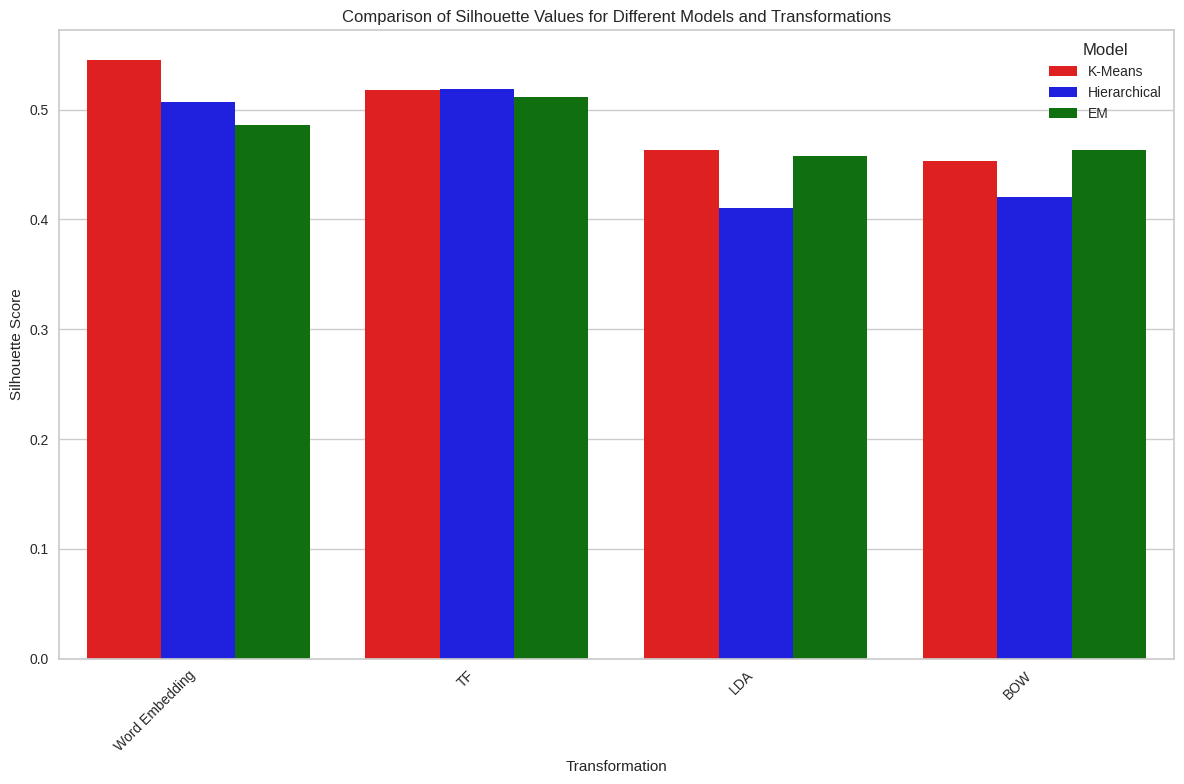

In [44]:
# Define a custom color palette
custom_palette = ["red",  "blue","green"]


# Create a bar plot with the custom color palette
plt.figure(figsize=(12, 8))
sns.barplot(x='Transformation', y='Score', hue='Model', data=silhouette_df, palette=custom_palette)
plt.xlabel('Transformation')
plt.ylabel('Silhouette Score')
plt.title('Comparison of Silhouette Values for Different Models and Transformations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


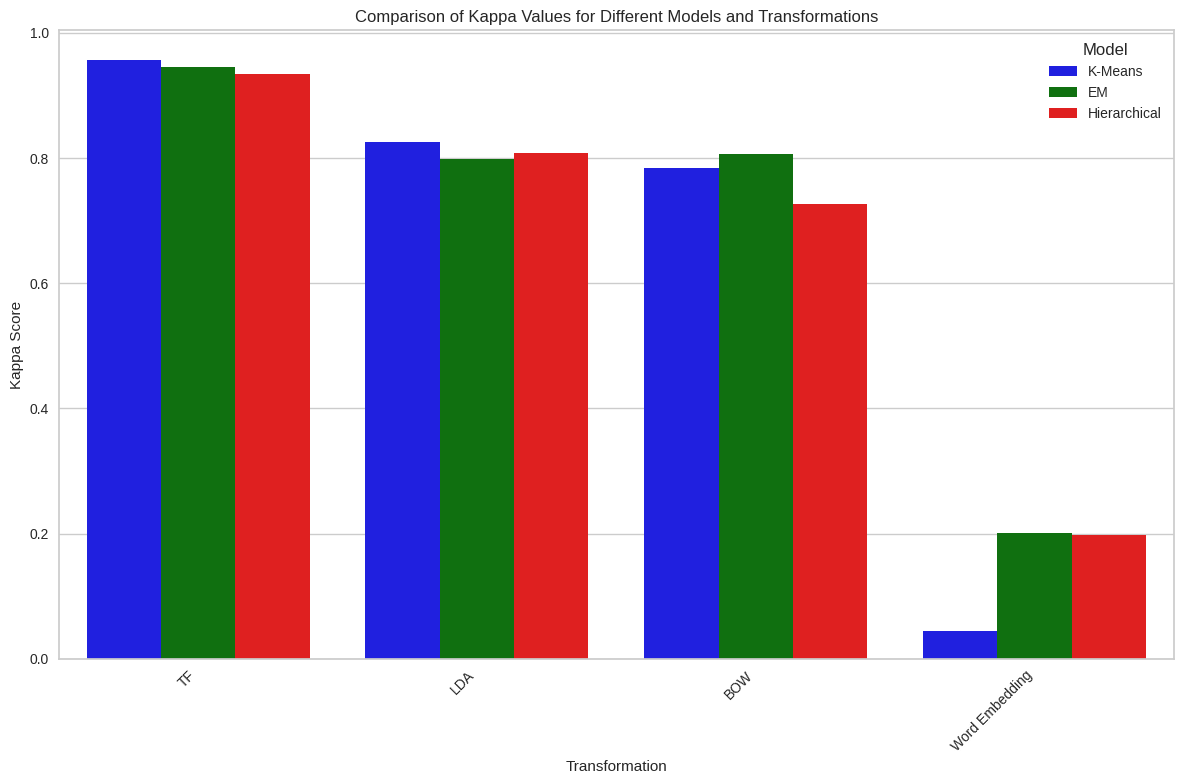

In [45]:
# Define a custom color palette
custom_palette = [ "blue", "green","red"]

# Create a bar plot with the custom color palette
plt.figure(figsize=(12, 8))
sns.barplot(x='Transformation', y='Score', hue='Model', data=kappa_df, palette=custom_palette)
plt.xlabel('Transformation')
plt.ylabel('Kappa Score')
plt.title('Comparison of Kappa Values for Different Models and Transformations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## **Coherence With LDA**

In [46]:
# create dictionary
dictionary = corpora.Dictionary(df["Partitions"].str.split())
#Term document frequency
corpus = [dictionary.doc2bow(text) for text in df["Partitions"].str.split()]

# 50 Topic
lda_model_5 = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = dictionary,
                                           num_topics = 5,
                                           random_state = 100,
                                           update_every = 1,
                                           chunksize = 100,
                                           passes = 10,
                                           alpha = 'auto',
                                           per_word_topics = True)
pred_5 = lda_model_5.inference(corpus)

In [47]:
# Compute Perplexity
perplexity_score = lda_model_5.log_perplexity(corpus)

# Compute Coherence using c_v
cm_cv = CoherenceModel(model=lda_model_5, texts=df["Partitions"].str.split(), dictionary=dictionary, coherence='c_v')
coherence_cv = round(cm_cv.get_coherence(), 4)

# Compute Coherence using u_mass
cm_umass = CoherenceModel(model=lda_model_5, texts=df["Partitions"].str.split(), dictionary=dictionary, coherence='u_mass')
coherence_umass = round(cm_umass.get_coherence(), 4)

# Create a DataFrame to store the scores
scores_df = pd.DataFrame({
    'Metric': ['Perplexity', 'Coherence (c_v)', 'Coherence (u_mass)'],
    'Score': [perplexity_score, coherence_cv, coherence_umass]
})

print("Scores DataFrame:")
scores_df.style.background_gradient(cmap='Blues')

Scores DataFrame:


,Metric,Score
0,Perplexity,-8.410242
1,Coherence (c_v),0.466800
2,Coherence (u_mass),-2.639600


## Error Analysis

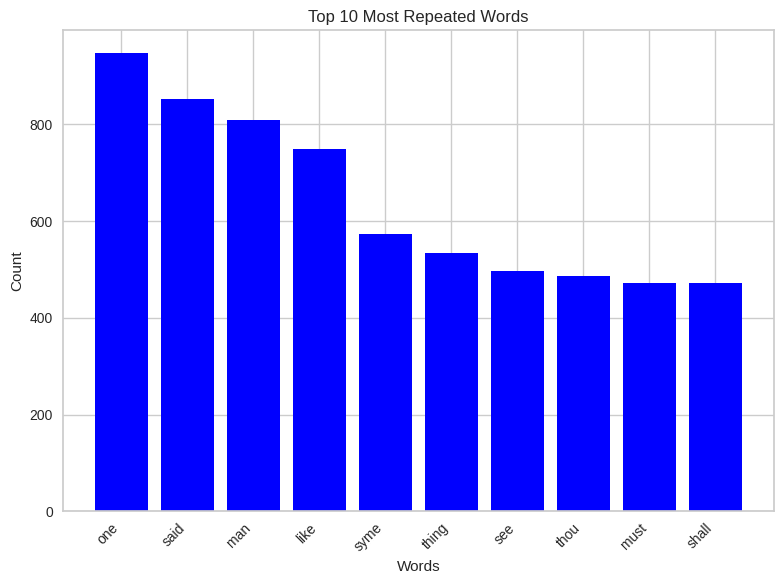

In [48]:
from collections import Counter

# Combine all book partitions into a single string
all_books = ' '.join(df["Partitions"])

# Count word occurrences
word_counts = Counter(all_books.split())

# Get the 10 most repeated words
top_words = word_counts.most_common(10)

# Plot the bar graph
plt.figure(figsize=(8, 6))
words, counts = zip(*top_words)
x = range(len(words))
plt.bar(x, counts, color='blue')
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Top 10 Most Repeated Words')
plt.xticks(x, words, rotation=45, ha='right')
plt.tight_layout()
plt.show()


# 3-Clusters

In [49]:
Silhouette3 = {'K-Means': set(), 'EM': set(), 'Hierarchical': set()}
Kappa3 = {'K-Means': set(), 'EM': set(), 'Hierarchical': set()}

# (1) K-Means

KMean With BOW

In [50]:
KMeans_Silhouette_BOW3,KMeans_Kappa_BOW3= C_ML_Models(X_BOW,3)

Silhouette3['K-Means'].add(('BOW', KMeans_Silhouette_BOW3))
Kappa3['K-Means'].add(('BOW',KMeans_Kappa_BOW3))


Silhouette Score (K-Means): 0.44281965494155884

Kappa Score (K-Means): 0.016368128474366972



KMean With LDA

In [51]:
KMeans_Silhouette_LDA3,KMeans_Kappa_LDA3 =C_ML_Models(X_LDA,3 )

Silhouette3['K-Means'].add(('LDA', KMeans_Silhouette_LDA3))
Kappa3['K-Means'].add(('LDA',KMeans_Kappa_LDA3))


Silhouette Score (K-Means): 0.43474724888801575

Kappa Score (K-Means): 0.30900621118012417



KMean With TF

In [52]:
KMeans_Silhouette_TF3,KMeans_Kappa_TF3=C_ML_Models(X_TF,3)

Silhouette3['K-Means'].add(('TF', KMeans_Silhouette_TF3))
Kappa3['K-Means'].add(('TF',KMeans_Kappa_TF3))


Silhouette Score (K-Means): 0.4640901982784271

Kappa Score (K-Means): 0.5944345766725874



KMean With Word Embedding

In [53]:
KMeans_Silhouette_WE3,KMeans_Kappa_WE3=C_ML_Models(X_Word_Embedding,3)

Silhouette3['K-Means'].add(('Word Embedding', KMeans_Silhouette_WE3))
Kappa3['K-Means'].add(('Word Embedding',KMeans_Kappa_WE3))


Silhouette Score (K-Means): 0.5085554718971252

Kappa Score (K-Means): 0.21220400728597444



## **(2) Expectation Maximization (EM)**

EM With BOW

In [54]:
EM_Silhouette_BOW3,EM_Kappa_BOW3=EM_ML_Models(X_BOW,3)

Silhouette3['EM'].add(('BOW', EM_Silhouette_BOW3))
Kappa3['EM'].add(('BOW',EM_Kappa_BOW3))


Silhouette Score (Expectation Maximization): 0.425220251083374

Kappa Score (Expectation Maximization): 0.3170028818443804



EM With LDA

In [55]:
EM_Silhouette_LDA3,EM_Kappa_LDA3=EM_ML_Models(X_LDA,3)

Silhouette3['EM'].add(('LDA', EM_Silhouette_LDA3))
Kappa3['EM'].add(('LDA',EM_Kappa_LDA3))


Silhouette Score (Expectation Maximization): 0.3927648663520813

Kappa Score (Expectation Maximization): 0.5535714285714286



EM With TF

In [56]:
EM_Silhouette_TF3,EM_Kappa_TF3=EM_ML_Models(X_TF,3)

Silhouette3['EM'].add(('TF', EM_Silhouette_TF3))
Kappa3['EM'].add(('TF',EM_Kappa_TF3))


Silhouette Score (Expectation Maximization): 0.45754310488700867

Kappa Score (Expectation Maximization): 0.05683947532792



EM With Word Embedding

In [57]:
EM_Silhouette_WE3,EM_Kappa_WE3=EM_ML_Models(X_Word_Embedding,3)

Silhouette3['EM'].add(('Word Embedding', EM_Silhouette_WE3))
Kappa3['EM'].add(('Word Embedding',EM_Kappa_WE3))



Silhouette Score (Expectation Maximization): 0.5198073387145996

Kappa Score (Expectation Maximization): 0.24653494544382193



## **(3) Hierarchical clustering (Agglomerative)**

Hierarchical clustering With BOW


Silhouette Score (Hierarchical) : 0.3856300115585327

Kappa Score (Hierarchical)  : 0.5001533272002454



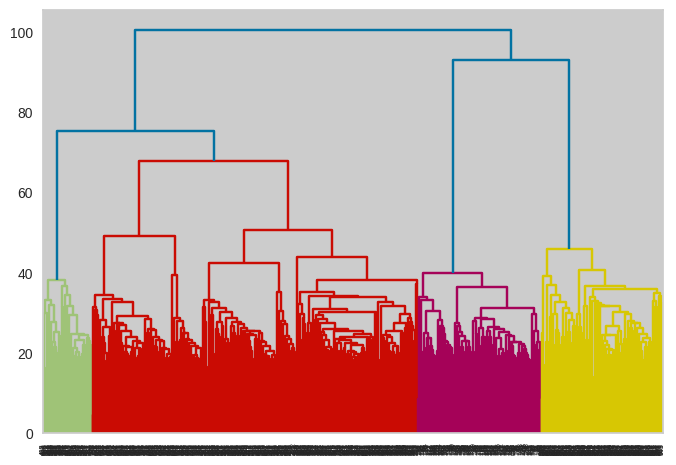

In [58]:
H_Silhouette_BOW3,H_Kappa_BOW3=H_MODEL(X_BOW,3)
perform_hierarchical_clustering(X_BOW)

Silhouette3['Hierarchical'].add(('BOW', H_Silhouette_BOW3))
Kappa3['Hierarchical'].add(('BOW',H_Kappa_BOW3))

Hierarchical clustering With LDA


Silhouette Score (Hierarchical) : 0.43439680337905884

Kappa Score (Hierarchical)  : 0.0666874415705827



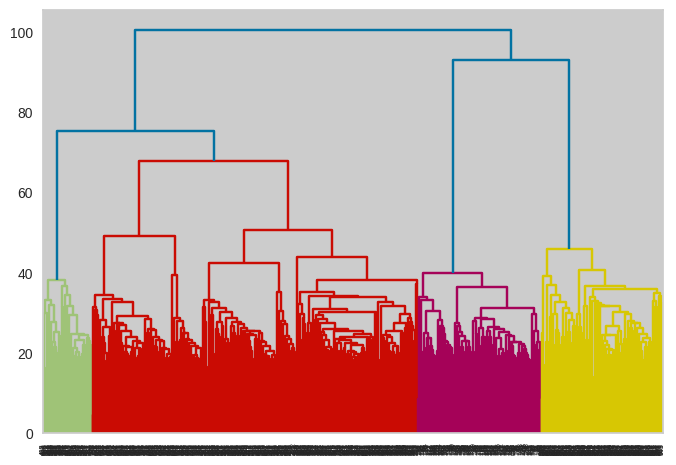

In [59]:
H_Silhouette_LDA3,H_Kappa_LDA3=H_MODEL(X_LDA,3)
perform_hierarchical_clustering(X_LDA)

Silhouette3['Hierarchical'].add(('LDA', H_Silhouette_LDA3))
Kappa3['Hierarchical'].add(('LDA',H_Kappa_LDA3))

Hierarchical clustering With TF


Silhouette Score (Hierarchical) : 0.4280955195426941

Kappa Score (Hierarchical)  : 0.381265664160401



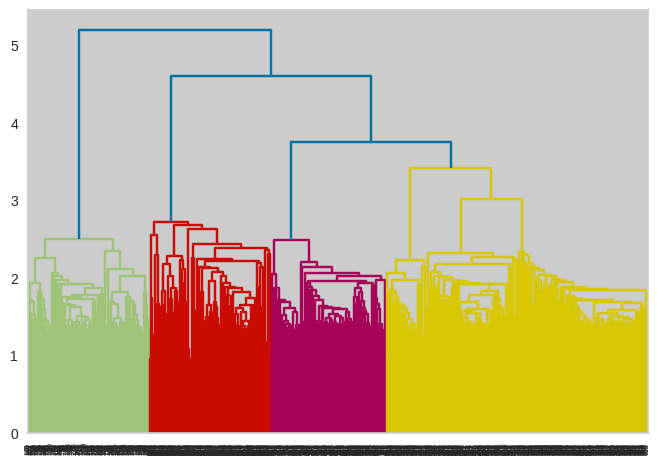

In [60]:
H_Silhouette_TF3,H_Kappa_TF3=H_MODEL(X_TF,3)
perform_hierarchical_clustering(X_TF)


Silhouette3['Hierarchical'].add(('TF', H_Silhouette_TF3))
Kappa3['Hierarchical'].add(('TF',H_Kappa_TF3))

Hierarchical clustering With Word Embedding


Silhouette Score (Hierarchical) : 0.4472225308418274

Kappa Score (Hierarchical)  : 0.303125



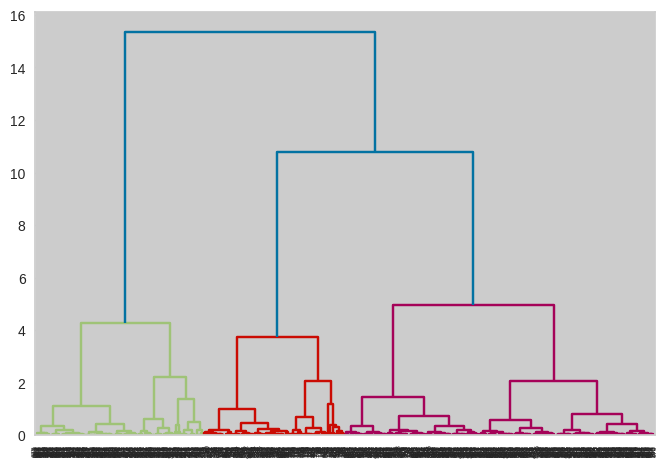

In [61]:
H_Silhouette_WE3, H_Kappa_WE3=H_MODEL(X_Word_Embedding,3)
perform_hierarchical_clustering(X_Word_Embedding)

Silhouette3['Hierarchical'].add(('Word Embedding', H_Silhouette_WE3))
Kappa3['Hierarchical'].add(('Word Embedding',H_Kappa_WE3))

## Champion Transformation/Model

In [73]:
# Initialize empty lists to store the data
silhouette_data3 = []
kappa_data3 = []

# Iterate over the Silhouette dictionary and append data to the lists
for model, transformations in Silhouette3.items():
    for transformation, score in transformations:
        silhouette_data3.append({'Model': model, 'Transformation': transformation, 'Score': score})

# Iterate over the Kappa dictionary and append data to the lists
for model, transformations in Kappa3.items():
    for transformation, score in transformations:
        kappa_data3.append({'Model': model, 'Transformation': transformation, 'Score': score})


# Create dataframes from the lists
silhouette_df3 = pd.DataFrame(silhouette_data3)
kappa_df3 = pd.DataFrame(kappa_data3)

# Sort dataframes by "Score" column in descending order
silhouette_df3 = silhouette_df3.sort_values(by='Score', ascending=False)
kappa_df3 = kappa_df3.sort_values(by='Score', ascending=False)

In [74]:
# Reset the index of the dataframes
silhouette_df3 = silhouette_df3.reset_index(drop=True)
kappa_df3 = kappa_df3.reset_index(drop=True)

In [75]:
# Print Silhouette dataframe
print("Silhouette DataFrame:")
silhouette_df3.style.background_gradient(cmap='Blues')

Silhouette DataFrame:


,Model,Transformation,Score
0,EM,Word Embedding,0.519807
1,K-Means,Word Embedding,0.508555
2,K-Means,TF,0.464090
3,EM,TF,0.457543
4,Hierarchical,Word Embedding,0.447223
5,K-Means,BOW,0.442820
6,K-Means,LDA,0.434747
7,Hierarchical,LDA,0.434397
8,Hierarchical,TF,0.428096
9,EM,BOW,0.425220


In [76]:
# Print Kappa dataframe
print("Kappa DataFrame:")
kappa_df3.style.background_gradient(cmap='Blues')

Kappa DataFrame:


,Model,Transformation,Score
0,K-Means,TF,0.594435
1,EM,LDA,0.553571
2,Hierarchical,BOW,0.500153
3,Hierarchical,TF,0.381266
4,EM,BOW,0.317003
5,K-Means,LDA,0.309006
6,Hierarchical,Word Embedding,0.303125
7,EM,Word Embedding,0.246535
8,K-Means,Word Embedding,0.212204
9,Hierarchical,LDA,0.066687


In [77]:
# Display the first element of the champion model dataframe
print("Champion Model Silhouette (First Element):")
champion_df_first = silhouette_df3.iloc[0].to_frame()
display(champion_df_first)

Champion Model Silhouette (First Element):


,0
Model,EM
Transformation,Word Embedding
Score,0.519807


In [78]:
# Display the first element of the champion model dataframe
print("Champion Model Kappa (First Element):")
champion_df_first =kappa_df3.iloc[0].to_frame()
display(champion_df_first)

Champion Model Kappa (First Element):


,0
Model,K-Means
Transformation,TF
Score,0.594435


In [79]:
# Define color palettes for each model
model_colors = {
    'K-Means':['red'],
    'EM': ['green'],
    'Hierarchical':  ['blue']
}

# Function to plot scores for a specific model
def plot_scores(model_name, df,name):
    model_df = df[df['Model'] == model_name]
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Transformation', y='Score', data=model_df, palette=model_colors[model_name])
    plt.xlabel('Transformation')
    plt.ylabel('Score')
    plt.title(f'{model_name} Scores for each Transformation using {name} value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

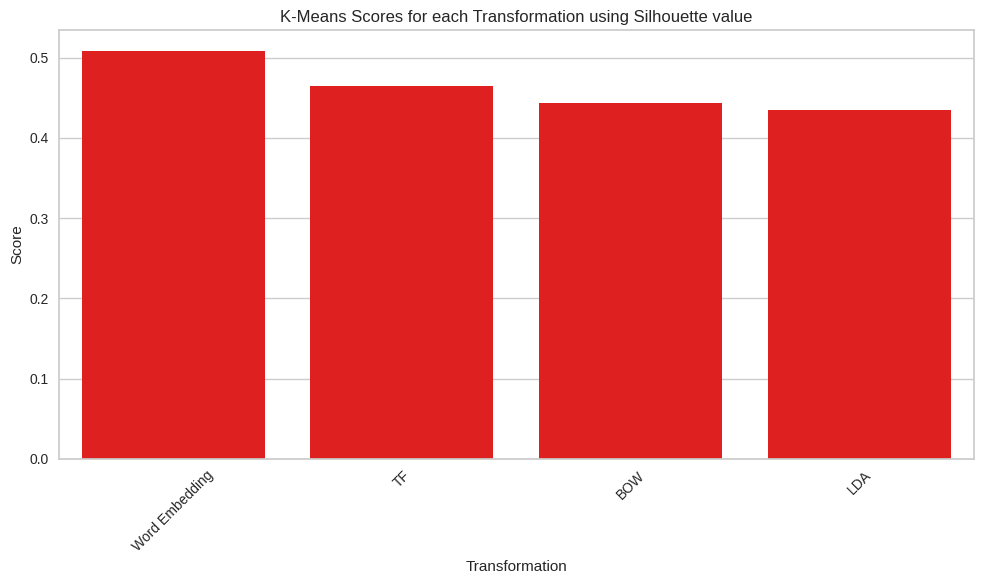

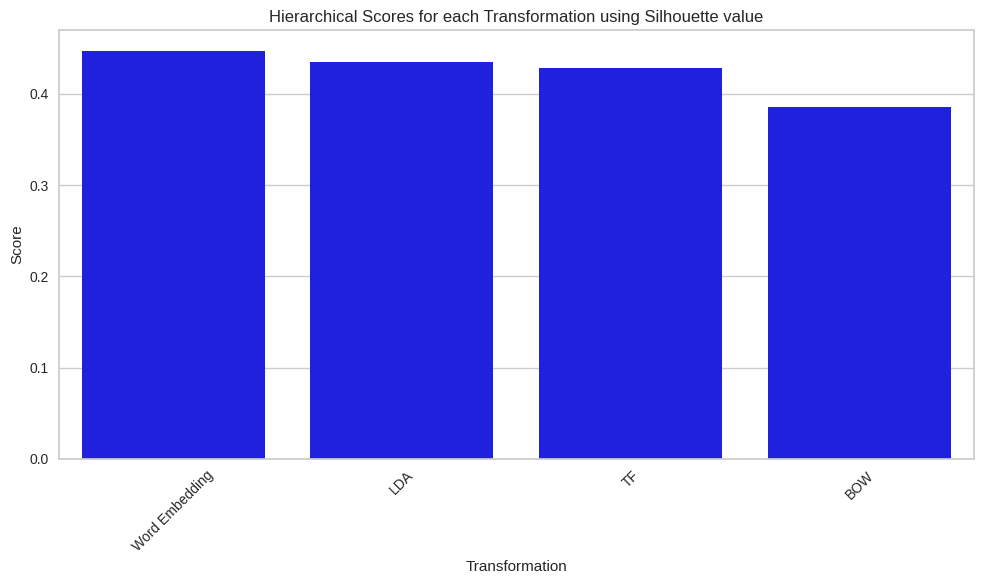

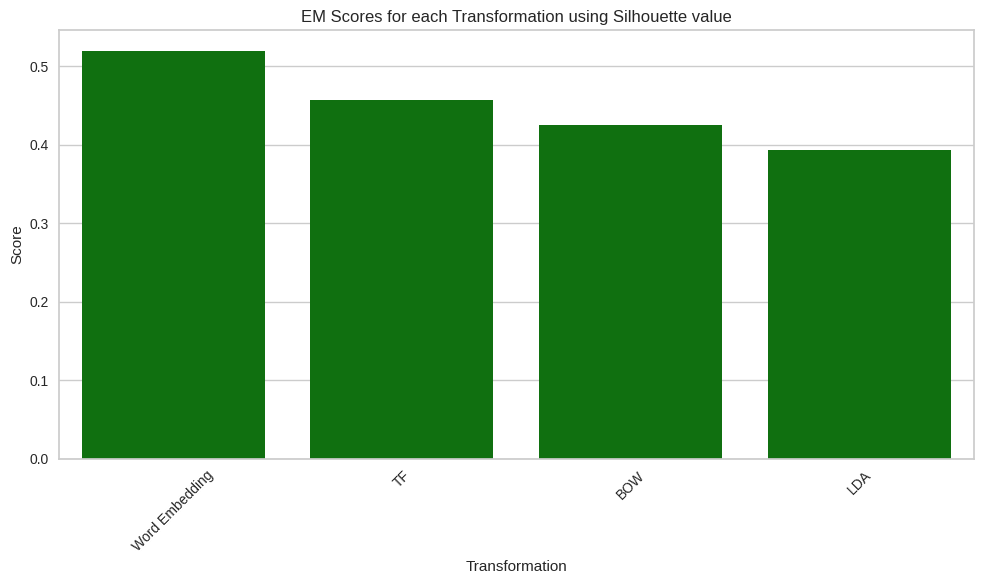

In [80]:
# Plot Silhouette scores for each model
for model in silhouette_df['Model'].unique():
    plot_scores(model, silhouette_df3 ,'Silhouette')

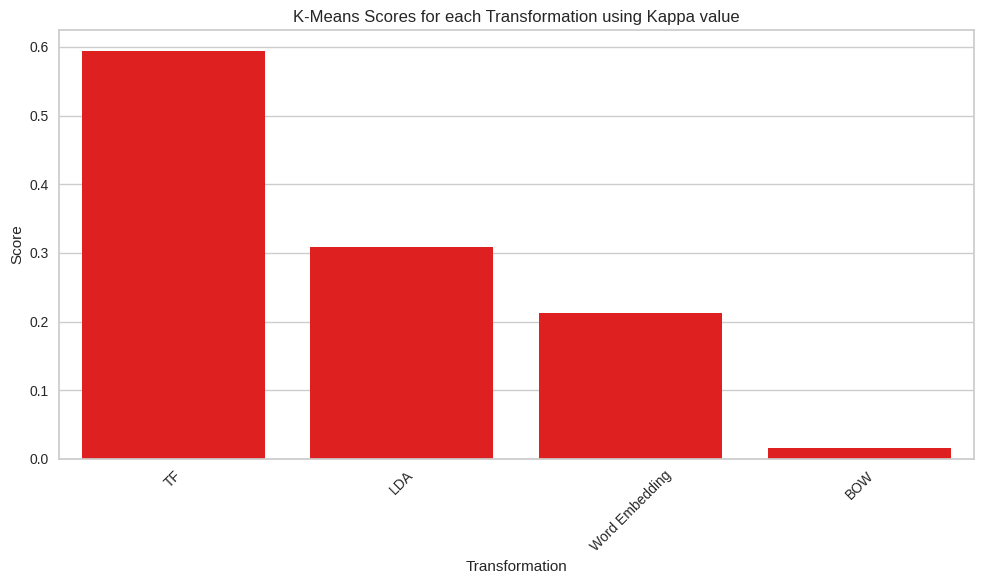

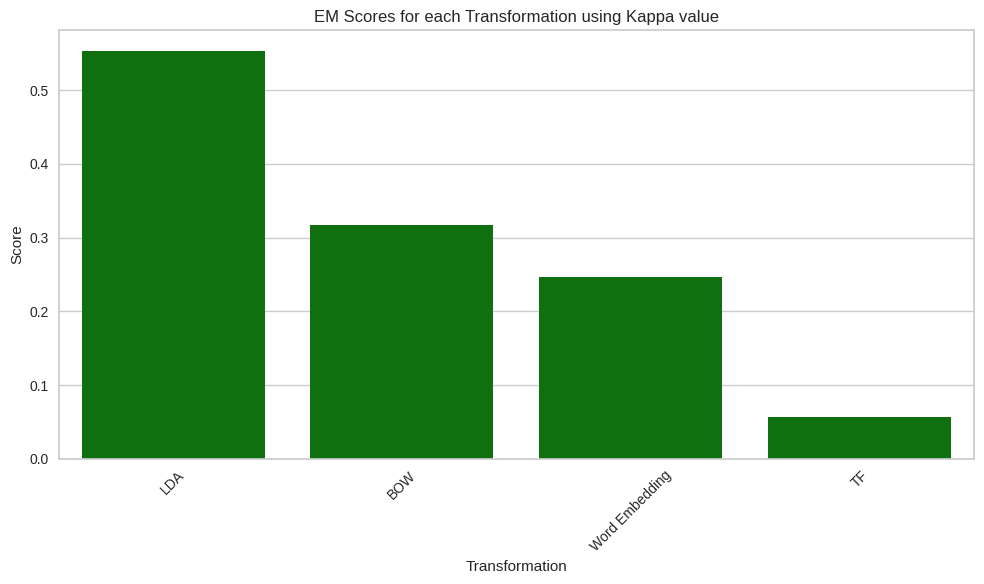

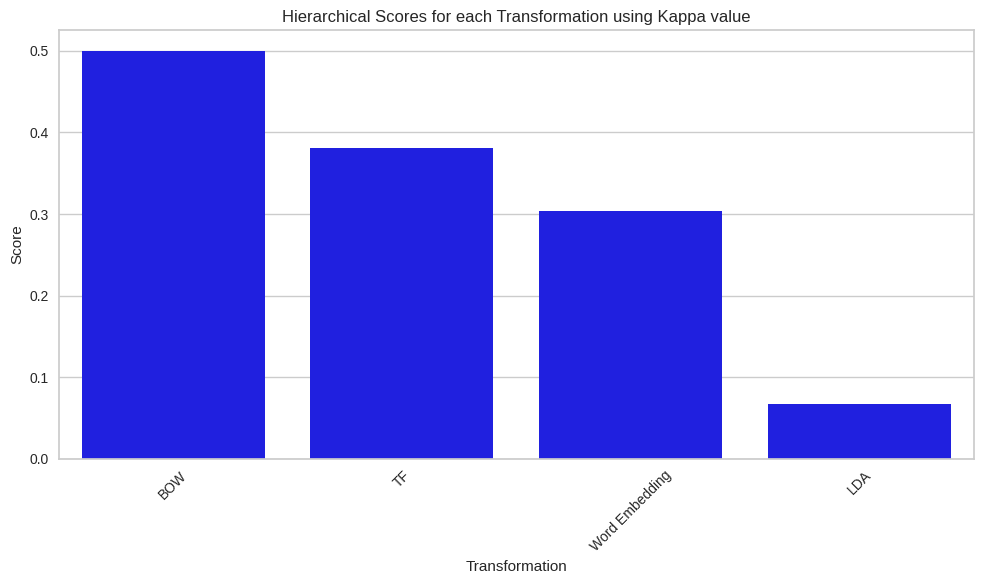

In [81]:
# Plot Kappa scores for each model
for model in kappa_df['Model'].unique():
    plot_scores(model, kappa_df3 ,"Kappa")


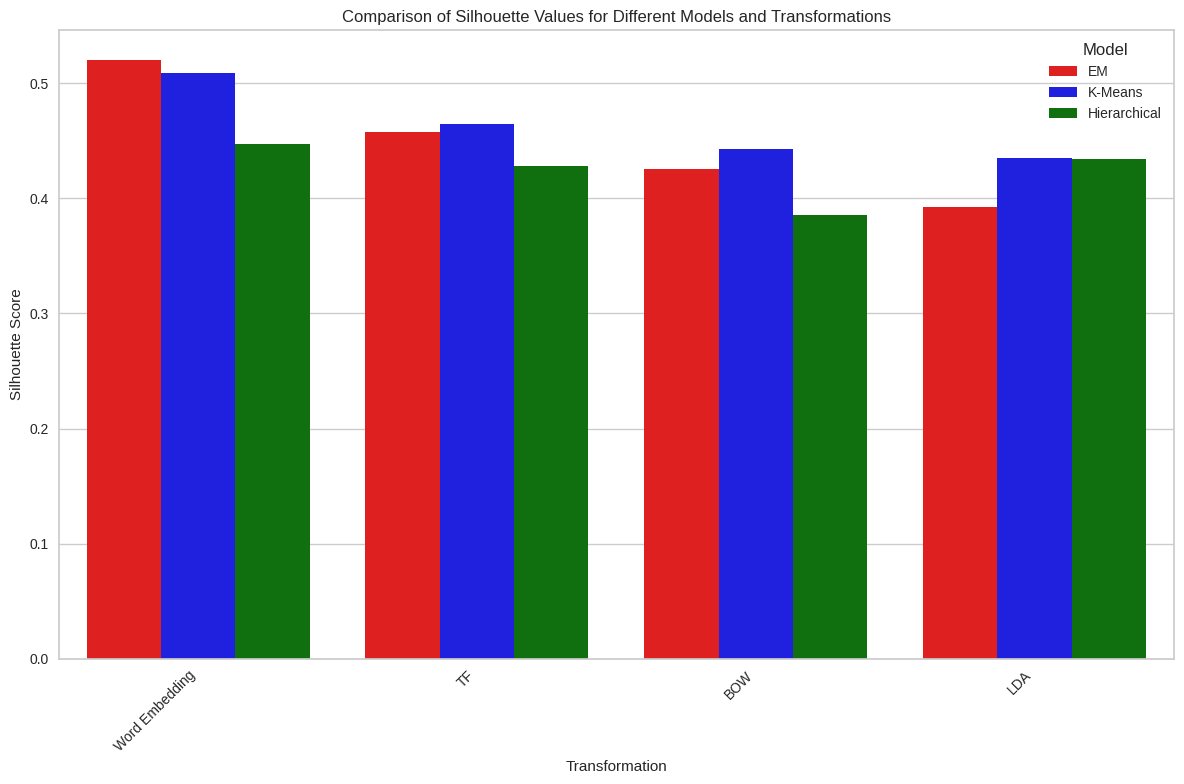

In [82]:
# Define a custom color palette
custom_palette = ["red",  "blue","green"]


# Create a bar plot with the custom color palette
plt.figure(figsize=(12, 8))
sns.barplot(x='Transformation', y='Score', hue='Model', data=silhouette_df3, palette=custom_palette)
plt.xlabel('Transformation')
plt.ylabel('Silhouette Score')
plt.title('Comparison of Silhouette Values for Different Models and Transformations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


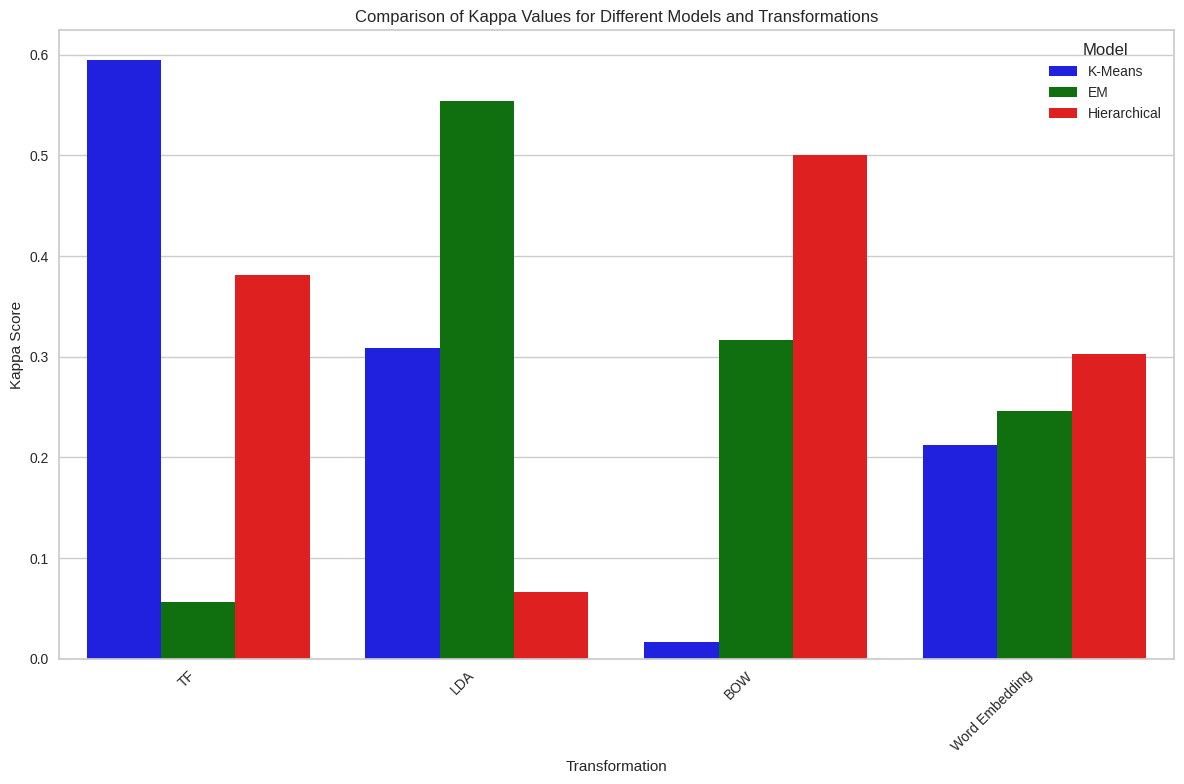

In [83]:
# Define a custom color palette
custom_palette = [ "blue", "green","red"]

# Create a bar plot with the custom color palette
plt.figure(figsize=(12, 8))
sns.barplot(x='Transformation', y='Score', hue='Model', data=kappa_df3, palette=custom_palette)
plt.xlabel('Transformation')
plt.ylabel('Kappa Score')
plt.title('Comparison of Kappa Values for Different Models and Transformations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
